#1)Importing Required libraries

In [1]:
# Step 1: Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
)


#2)Loading the dataset

In [2]:
# Step 2: Load dataset
df = pd.read_csv("./diabetes.csv")

# Preview dataset
print(df.head())
print(df.info())
print(df.describe())


   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768

#3)Exploratory Data Analysis(EDA)

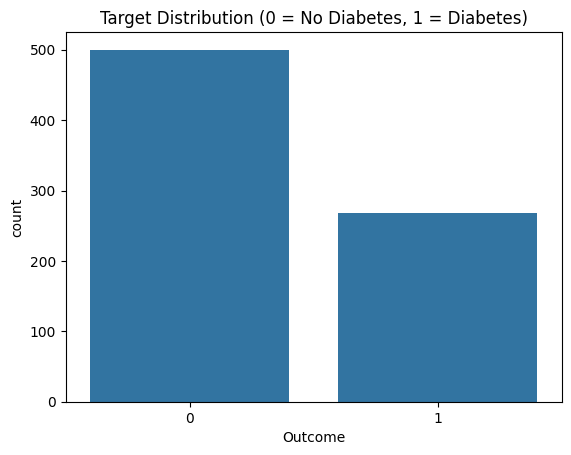

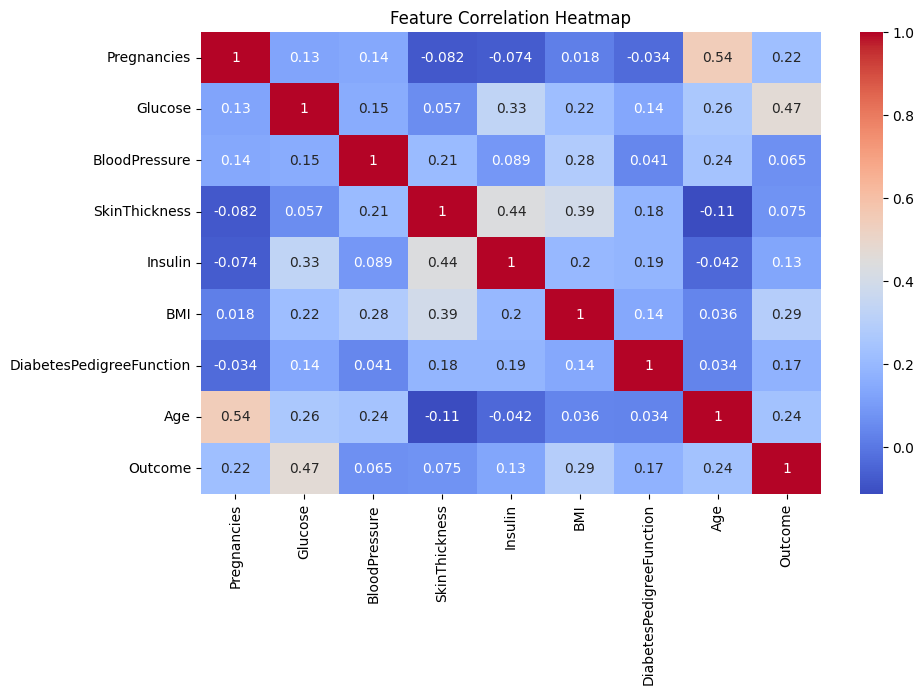

In [3]:
# Step 3: Basic EDA
# Check target distribution
sns.countplot(x='Outcome', data=df)
plt.title("Target Distribution (0 = No Diabetes, 1 = Diabetes)")
plt.show()

# Correlation heatmap
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm")
plt.title("Feature Correlation Heatmap")
plt.show()


#4)Dealing with missing values

In [4]:
# Step 4: Robust handling of missing/invalid values

# 1. Check for NaN values first
print("NaN values per column:")
print(df.isnull().sum())

# 2. Check if there are columns with 0 values that don't make sense
# (Glucose, BloodPressure, SkinThickness, Insulin, BMI can't realistically be 0)
cols_with_invalid_zeros = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

for col in cols_with_invalid_zeros:
    zero_count = (df[col] == 0).sum()
    if zero_count > 0:
        print(f"Column '{col}' has {zero_count} invalid zero values out of {len(df)}")

# 3. Replace invalid zeros with NaN for further imputation
df[cols_with_invalid_zeros] = df[cols_with_invalid_zeros].replace(0, np.nan)

# 4. Re-check missing values after conversion
print("\nMissing values after replacing zeros with NaN:")
print(df.isnull().sum())

# 5. Decide imputation strategy column by column
for col in cols_with_invalid_zeros:
    missing = df[col].isnull().sum()
    if missing > 0:
        # Strategy:
        # - Continuous columns → use median (robust against outliers)
        median_val = df[col].median()
        df[col].fillna(median_val, inplace=True)
        print(f"Filled {missing} missing values in '{col}' with median = {median_val}")


NaN values per column:
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64
Column 'Glucose' has 5 invalid zero values out of 768
Column 'BloodPressure' has 35 invalid zero values out of 768
Column 'SkinThickness' has 227 invalid zero values out of 768
Column 'Insulin' has 374 invalid zero values out of 768
Column 'BMI' has 11 invalid zero values out of 768

Missing values after replacing zeros with NaN:
Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64
Filled 5 missing values in 'Glucose' with median = 117.0
Fill

/tmp/ipython-input-1557206512.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(median_val, inplace=True)


#5)Data splitting


In [5]:
# Step 5: Split into train and test
X = df.drop("Outcome", axis=1)
y = df["Outcome"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


#6)Feature Scaling

In [6]:
# Step 6: Feature scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


#7)Training the logistic Regression Model

In [7]:
# Step 7: Train Logistic Regression model
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

# Predictions
y_pred = log_reg.predict(X_test)
y_pred_prob = log_reg.predict_proba(X_test)[:,1]


#8)Evaluation

Accuracy: 0.7077922077922078
Precision: 0.6
Recall: 0.5
F1 Score: 0.5454545454545454


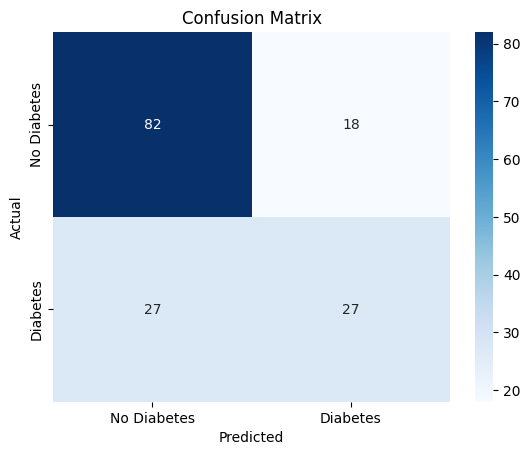

In [8]:
# Step 8: Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Diabetes","Diabetes"], yticklabels=["No Diabetes","Diabetes"])
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.title("Confusion Matrix")
plt.show()


#9)ROC curve

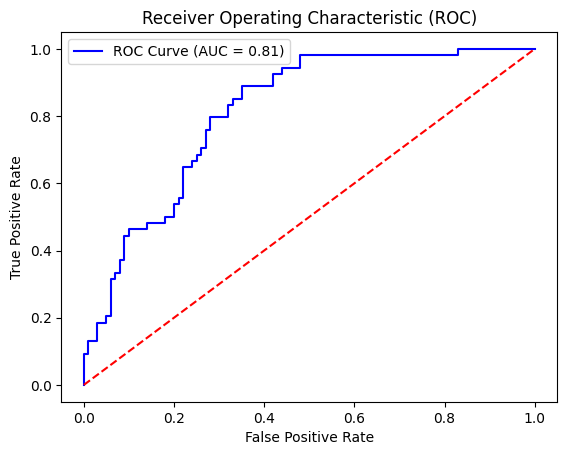

In [9]:
# Step 9: ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='blue', label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0,1],[0,1], color='red', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC)")
plt.legend()
plt.show()


#10)Cross-Validation

In [10]:
# Step 10: Cross-validation
cv_scores = cross_val_score(log_reg, X, y, cv=5, scoring='accuracy')
print("Cross-validation Accuracy Scores:", cv_scores)
print("Mean CV Accuracy:", cv_scores.mean())


Cross-validation Accuracy Scores: [0.75974026 0.74025974 0.78571429 0.79738562 0.77777778]
Mean CV Accuracy: 0.7721755368814192
